In [1]:
!pip install notebook pandas geopandas shapely duckdb jupysql duckdb-engine

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.6/323.6 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 46.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.1/95.1 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.8/192.8 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.8/27.8 MB 57.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 96.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 50.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.6/462.6 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 583.9/583.9 kB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.7/96.7 k

In [2]:
# import our toolkit
import pandas as pd
import geopandas as gpd
from shapely import wkt
import duckdb

In [3]:
# no need to import duckdb_engine, JupySQL will auto-detect driver
# load (or reload) jupysql Jupyter extension to create SQL cells
%reload_ext sql

In [4]:
# DuckDB in-memory database
%sql duckdb://

Connecting to 'duckdb://'

In [5]:
# Run if error
#%sql ROLLBACK

In [6]:
%sql INSTALL spatial;
%sql INSTALL httpfs;
%sql LOAD spatial;
%sql LOAD httpfs;
%sql SET s3_region='us-west-2'

Running query in 'duckdb://'

Running query in 'duckdb://'

Running query in 'duckdb://'

Running query in 'duckdb://'

Running query in 'duckdb://'

Success


In [7]:
%%sql
COPY(
    SELECT
        id,
        names.primary AS name,
        CAST(addresses AS JSON) AS addresses,
        confidence,
        geometry
    FROM read_parquet(
        's3://overturemaps-us-west-2/release/2025-04-23.0/theme=places/type=place/*',
        filename=true,
        hive_partitioning=1
    )
    WHERE bbox.xmin BETWEEN -121.91 AND -121.87
      AND bbox.ymin BETWEEN 37.41 AND 37.42
) TO 'greatmall_pois.geojson' WITH (FORMAT GDAL, DRIVER 'GeoJSON');

Running query in 'duckdb://'

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Count


<Axes: >

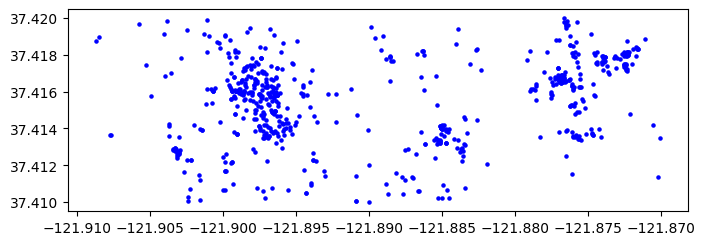

In [8]:
pois_gdf = gpd.read_file("greatmall_pois.geojson")
pois_gdf.plot(markersize=5, color="blue", figsize=(8, 8))

In [9]:
# Load your points from GeoJSON
points_gdf = gpd.read_file("greatmall_pois.geojson")

# Check the current coordinate system (likely EPSG:4326 for lat/lon)
print(points_gdf.crs)

EPSG:4326


In [10]:
# Reproject to UTM Zone 10N (EPSG:32610)
points_gdf_utm = points_gdf.to_crs(epsg=32610)

# Now you can calculate distances in meters

In [11]:
dist = points_gdf_utm.geometry.iloc[0].distance(points_gdf_utm.geometry.iloc[1])
print(f"Distance between first two points: {dist:.8f} meters")

Distance between first two points: 5.07682231 meters


In [12]:
points_gdf = gpd.read_file("greatmall_pois.geojson")
points_gdf = points_gdf.to_crs(epsg=32610)  # UTM Zone 10N for Milpitas area

In [13]:
point_a = points_gdf[points_gdf["name"] == "Kelly's Cajun Grill"].geometry.iloc[0]
point_b = points_gdf[points_gdf["name"] == "Hot Dog on a Stick"].geometry.iloc[0]
distance = point_a.distance(point_b)  # in meters
print(f"Distance: {distance:.2f} meters")

Distance: 19.59 meters


In [14]:
import numpy as np

# Create distance matrix
dist_matrix = points_gdf.geometry.apply(lambda g: points_gdf.distance(g))
print(dist_matrix)

# Mask out self-comparisons (distance = 0)
np.fill_diagonal(dist_matrix.values, np.nan)

# Identify near-overlaps (e.g., < 1 meter)
too_close = (dist_matrix < 20.0) & (~dist_matrix.isna())

             0            1            2            3            4    \
0       0.000000     5.076822   345.745422   574.451861   593.831338   
1       5.076822     0.000000   341.228490   573.742231   592.944560   
2     345.745422   341.228490     0.000000   469.303021   472.765562   
3     574.451861   573.742231   469.303021     0.000000    28.238966   
4     593.831338   592.944560   472.765562    28.238966     0.000000   
..           ...          ...          ...          ...          ...   
687  2843.400098  2838.329385  2549.099247  2846.595521  2827.937218   
688  2853.922372  2848.852819  2560.454037  2859.448916  2840.867351   
689  2838.121263  2833.047890  2541.521420  2834.459054  2815.556382   
690  2852.488760  2847.416816  2557.172846  2852.518721  2833.738330   
691  2912.320147  2907.249941  2618.249279  2915.285546  2896.566060   

             5            6            7            8            9    ...  \
0     479.502652   696.582667   615.103684   603.199680   

In [15]:
# This assumes your GeoDataFrame has a 'name' column
names = points_gdf["name"].reset_index(drop=True)

# Create a dictionary to hold results
close_names = {}

for i, row in too_close.iterrows():
    close_to = names[row]
    if not close_to.empty:
        close_names[names[i]] = list(close_to.values)

In [16]:
for base, others in close_names.items():
    print(f"'{base}' is too close to: {others}")

'Cal Fire' is too close to: ['Dogs park milpitas']
'Dogs park milpitas' is too close to: ['Cal Fire']
'King of Locks' is too close to: ['Graham at The Fields']
'Graham at The Fields' is too close to: ['King of Locks']
'Sydney Beauty Salon' is too close to: ['Juban Ramen & Tapas']
'Juban Ramen & Tapas' is too close to: ['Sydney Beauty Salon', 'Liberty Plaza Dental', 'Super Spin Table Tennis Club', 'Uptone Music School', 'Tran M Anthony, DC']
'ILARA Apartments' is too close to: ['Walnut Education']
'Walnut Education' is too close to: ['ILARA Apartments']
'Smart Learning Academy' is too close to: ['Bikram Yoga Milpitas', 'Tirupathi Bhimas', 'Green Skincare and Cosmetic', 'Zhiping Shi Dance', 'Milpitas Windshield Shop 510-470-7778', 'Apple Salon', 'An Phan: Allstate Insurance']
'Bikram Yoga Milpitas' is too close to: ['Smart Learning Academy', 'Tirupathi Bhimas', 'Green Skincare and Cosmetic', 'Apple Salon', 'An Phan: Allstate Insurance']
'Tirupathi Bhimas' is too close to: ['Smart Learnin

In [17]:
for i, row in too_close.iterrows():
    base_name = names[i]
    for j, is_close in row.items():
        if is_close:
            other_name = names[j]
            distance = dist_matrix.iloc[i, j]
            print(f"'{base_name}' is {distance:.2f} meters from '{other_name}'")

'Cal Fire' is 5.08 meters from 'Dogs park milpitas'
'Dogs park milpitas' is 5.08 meters from 'Cal Fire'
'King of Locks' is 13.53 meters from 'Graham at The Fields'
'Graham at The Fields' is 13.53 meters from 'King of Locks'
'Sydney Beauty Salon' is 12.81 meters from 'Juban Ramen & Tapas'
'Juban Ramen & Tapas' is 12.81 meters from 'Sydney Beauty Salon'
'Juban Ramen & Tapas' is 11.74 meters from 'Liberty Plaza Dental'
'Juban Ramen & Tapas' is 13.87 meters from 'Super Spin Table Tennis Club'
'Juban Ramen & Tapas' is 12.52 meters from 'Uptone Music School'
'Juban Ramen & Tapas' is 13.98 meters from 'Tran M Anthony, DC'
'ILARA Apartments' is 5.18 meters from 'Walnut Education'
'Walnut Education' is 5.18 meters from 'ILARA Apartments'
'Smart Learning Academy' is 11.51 meters from 'Bikram Yoga Milpitas'
'Smart Learning Academy' is 14.19 meters from 'Tirupathi Bhimas'
'Smart Learning Academy' is 7.29 meters from 'Green Skincare and Cosmetic'
'Smart Learning Academy' is 11.06 meters from 'Zhipi

In [25]:
from shapely.affinity import translate
import random

min_distance = 20  # meters
max_iterations = 100
adjusted_gdf = points_gdf.copy()
def repulsion_vector(p1, p2):
    dx = p1.x - p2.x
    dy = p1.y - p2.y
    dist = np.hypot(dx, dy)
    if dist == 0:
        angle = random.uniform(0, 2 * np.pi)
        return np.cos(angle), np.sin(angle)
    return dx / dist, dy / dist

# Iterative separation
for _ in range(max_iterations):
    moved = False
    for i, geom_i in adjusted_gdf.geometry.items():
        for j, geom_j in adjusted_gdf.geometry.items():
            if i >= j:
                continue
            dist = geom_i.distance(geom_j)
            if dist < min_distance:
                moved = True
                dx, dy = repulsion_vector(geom_i, geom_j)
                shift = (min_distance - dist) / 2 + 0.01
                adjusted_gdf.at[i, "geometry"] = translate(geom_i, xoff=dx * shift, yoff=dy * shift)
                adjusted_gdf.at[j, "geometry"] = translate(geom_j, xoff=-dx * shift, yoff=-dy * shift)
    if not moved:
        print("All overlaps resolved.")
        break
else:
    print("Max iterations reached, some overlaps may remain.")


All overlaps resolved.


In [26]:
# Final validation
final_dist_matrix = adjusted_gdf.geometry.apply(lambda g: adjusted_gdf.distance(g))
np.fill_diagonal(final_dist_matrix.values, np.nan)
print("Remaining overlaps < 20m:", (final_dist_matrix < 20).any().any())

Remaining overlaps < 20m: False


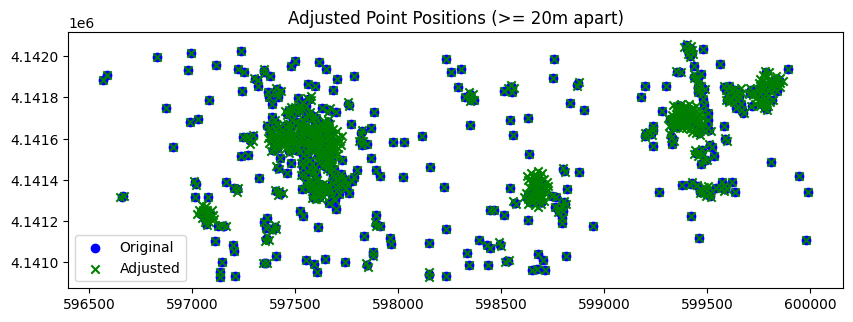

In [28]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))
points_gdf.plot(ax=ax, color="blue", label="Original")
adjusted_gdf.plot(ax=ax, color="green", marker="x", label="Adjusted")
plt.legend()
plt.title("Adjusted Point Positions (>= 20m apart)")
plt.show()

In [29]:
adjusted_gdf.to_crs(epsg=4326).to_file("greatmall_pois_adjusted.geojson", driver="GeoJSON")